In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

from cfollmer.objectives import log_g, relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE
import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

## Generating Toy 2D Dataset.

In [2]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
random_state = 170

X, y = make_blobs(n_samples=300,
                  cluster_std=[0.5, 0.5, 0.5],
                  random_state=random_state)

X = X[y==0,:]
y = y[y==0]
# # Scale data to have mean 0 and variance 1 
# # which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

In [3]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

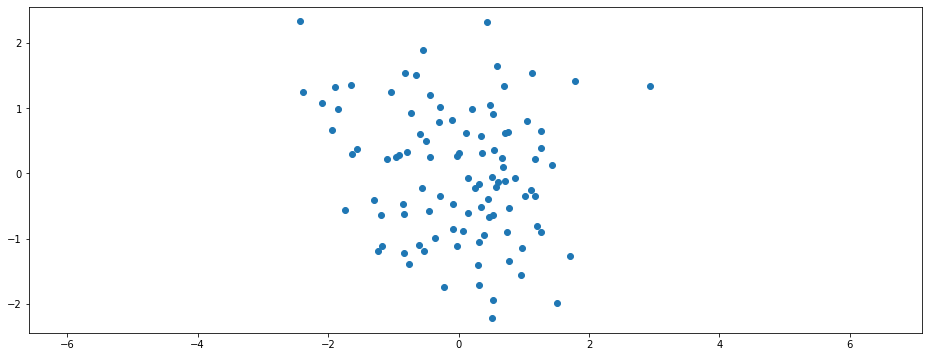

In [4]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

ax1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o')

ax1.axis('equal');

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation.

In [5]:
def log_gaussian(x, mean=0):
    """
    Returns the density of x under the supplied gaussian. Defaults to
    standard gaussian N(0, I)
    :param x: (*) torch.Tensor
    :param mean: float or torch.FloatTensor with dimensions (*)
    :param logvar: float or torch.FloatTensor with dimensions (*)
    :return: (*) elementwise log density
    """
    
    log_norm_constant = -0.5 * np.log(2 * np.pi)
    
    var =  torch.tensor(0.1)
    logvar = torch.log(var).reshape(1,1).to(device)
    
    A = (x - mean) ** 2
    log_p = -0.5 * (logvar + A / logvar.exp())
    log_p = log_p + log_norm_constant
#     import pdb; pdb.set_trace()
    return log_p.sum(dim=-1)



def ln_prior(Θ, σ_w=1):
    """
    Prior for means in Bayesian GMM
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w


def log_likelihood_single(μ, X, log=True):
    """
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param logvar: the component log-variances (K, features)
    :param log: return value in log domain?

    """
    
    n, d = X.shape
    # get feature-wise log-likelihoods (K, examples, features)
    log_likelihoods = log_gaussian(
        X[None, :, :], 
        μ.reshape(1, d)[:, None, :], 
    )

    return log_likelihoods.sum()


def log_likelihood(Θ, X, y=None):
    """
    batching the above (hopefully its right)
    """

    loss_ = lambda μ: log_likelihood_single(μ, X)
    
    batched_loss =  torch._vmap_internals.vmap(loss_)

    return batched_loss(Θ)

In [6]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim =  2

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [7]:
relative_entropy_control_cost(sde, Θ_0, X_train, y_train, 
                              ln_prior, log_likelihood, γ=1.0, device=device)

C:\Users\vargf\anaconda3\lib\site-packages\torch\_vmap_internals.py:252: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk.
  warnings.warn(
<ipython-input-5-bd9d1ba955c7>:47: UserWarning: Batching rule not implemented for aten::sum falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  return log_likelihoods.sum()


tensor(1641.5288, device='cuda:0', grad_fn=<MeanBackward0>)

In [8]:
γ = 1.0
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.01, weight_decay =1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 300

train = False
if train:
    for i in tqdm(range(num_steps)):
        optimizer.zero_grad()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                loss = relative_entropy_control_cost(
                    sde, Θ_0.float(),
                    X_train.float(), y_train.float(),
                    ln_prior, log_likelihood, γ=γ
                )
                optimizer.zero_grad()
                loss.backward()
                return loss

            optimizer.step(closure)
            losses.append(closure().item())
        else:
            loss = relative_entropy_control_cost(
                sde, Θ_0,
                X_train, y_train,
                ln_prior, log_likelihood, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            losses.append(loss.item())

20


In [9]:
losses

[]

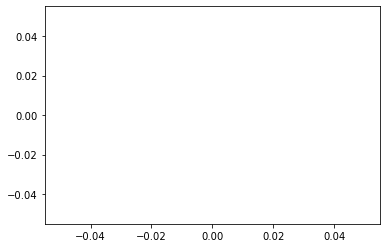

In [10]:
plt.plot(losses[:])

In [11]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([20, 50, 2])

In [12]:
torch.eye(3,2)

tensor([[1., 0.],
        [0., 1.],
        [0., 0.]])

In [68]:
# Mannualy doing one step of Euler

Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[1,...]

In [28]:
Θ_1 = Θ_1.reshape(50,2)

(array([ 7.,  4.,  7.,  9., 12.,  4.,  3.,  2.,  1.,  1.]),
 array([-0.44750333, -0.3341019 , -0.22070046, -0.10729901,  0.00610242,
         0.11950386,  0.2329053 ,  0.34630674,  0.45970815,  0.5731096 ,
         0.68651104], dtype=float32),
 <a list of 10 Patch objects>)

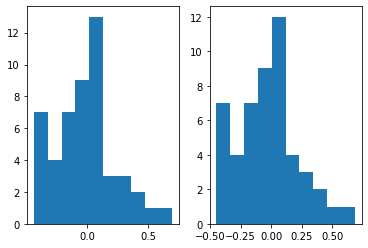

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(Θ_1[:,0].flatten().cpu().detach().numpy())
ax2.hist(Θ_1[:,1].flatten().cpu().detach().numpy())

In [69]:

# Manually doing 2 steps of euler 
Θ_2 = sde.f(0, 
        sde.f(0, Θ_0) * Δt + torch.normal(0,math.sqrt(Δt), (Θ_0.shape[0], Θ_0.shape[1]) ).to(device)
    ) * Δt +  torch.normal(0,math.sqrt(Δt), (Θ_0.shape[0], Θ_0.shape[1]) ).to(device)

In [70]:
Θ_2

tensor([[ 0.1129,  0.1308],
        [ 0.3835,  0.2110],
        [-0.0040, -0.3673],
        [-0.2253, -0.2339],
        [-0.0446,  0.2219],
        [-0.0588, -0.0681],
        [ 0.0242, -0.0415],
        [ 0.0965,  0.0154],
        [ 0.5100,  0.1542],
        [ 0.0887, -0.0229],
        [-0.3841,  0.2924],
        [-0.1314,  0.2689],
        [-0.0991,  0.3550],
        [ 0.0971, -0.4236],
        [ 0.1422,  0.0194],
        [-0.1350, -0.1847],
        [-0.0988,  0.2104],
        [ 0.1661, -0.3192],
        [-0.2309,  0.0242],
        [ 0.3489,  0.2536],
        [-0.1444, -0.0363],
        [ 0.3593, -0.2336],
        [-0.5580, -0.3791],
        [ 0.2069, -0.3593],
        [-0.2853, -0.1869],
        [ 0.1933, -0.1933],
        [ 0.2893, -0.2705],
        [-0.2836, -0.3598],
        [-0.3511,  0.2740],
        [ 0.1856, -0.1775],
        [ 0.3283,  0.4538],
        [ 0.0764,  0.1144],
        [-0.0851, -0.7038],
        [-0.2150, -0.1683],
        [ 0.0619,  0.5093],
        [-0.2449,  0

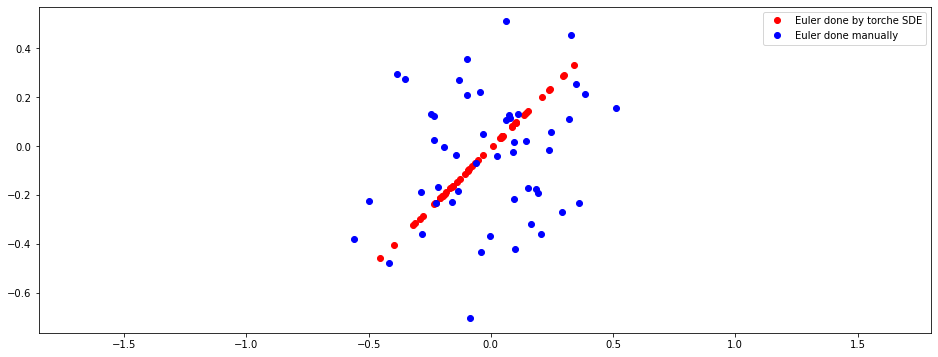

In [71]:
fig, ax_1 = plt.subplots(1, 1, figsize=(16, 6))
Θ_plot = Θ_1.cpu().detach() #.reshape(50*3,2)

Θ_plot2 = Θ_2.cpu().detach() 



ax_1.plot(Θ_plot[:, 0], Θ_plot[:, 1], 
         linestyle='none', 
         marker='o', color="red", label="Euler done by torche SDE")

ax_1.plot(Θ_plot2[:, 0], Θ_plot2[:, 1], 
         linestyle='none', 
         marker='o', color="blue", label="Euler done manually")

# ax_1.plot(X_scaled[:, 0], X_scaled[:, 1], 
#          linestyle='none', 
#          marker='o', label="Observations $X$")

ax_1.legend()
ax_1.axis('equal');

In [19]:
Θ_plot[:, 0]-Θ_plot[:, 1]

tensor([ 0.1793,  0.1312,  0.0910,  0.2549,  0.1410,  0.0585,  0.1621,  0.1637,
         0.2204,  0.0843,  0.0656,  0.0881,  0.1349,  0.1894,  0.1220,  0.2094,
         0.2215,  0.1651,  0.0495,  0.1466,  0.1212,  0.0617,  0.1152,  0.1255,
         0.0891,  0.1635,  0.1823,  0.2343,  0.1153,  0.1324,  0.1912,  0.1300,
         0.1652,  0.2043,  0.2035,  0.3616,  0.2387,  0.0995,  0.2329,  0.1757,
         0.1981,  0.1266,  0.1408, -0.0010,  0.2378,  0.2390,  0.0642,  0.2355,
         0.1346,  0.1499])

## MAP Baseline

We run the point estimate approximation (Maximum a posteriori) to double check what the learned weights look like.  We get the  exact same training accuracy as with the controlled model and similarly large weights for the non bias weights. 

In [30]:
Θ_map = torch.full((1, dim), 0.0, requires_grad=True)  
optimizer_map = torch.optim.Adam([Θ_map], lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 1000
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, (X_train).float(), (y_train).float()) + gaussian_prior(Θ_map))
        optimizer_map.zero_grad()
        loss_map.backward()

        optimizer_map.step()
        losses_map.append(loss.item())

Θ_map
pred_map = torch.sigmoid(X_train.float().mm(Θ_map.T)).mean(axis=1)
((pred_map < 0.5).float() == y_train).float().mean(), Θ_map

  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'log_likelihood_vmap' is not defined

AttributeError: module 'torch' has no attribute 'eye_like'